In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from copy import deepcopy
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import sys
import math


In [2]:
r = 0.033*20
L = 0.35*20

In [3]:
# node class that each spot in the map will occupy
# cell location and goal_location are tuples representing index 
# of current cell location and goal cell locations
# local path represents the path to get to this 
# node from the optimal parent node
class Node:
    def __init__(self, parent, cell_location, region, c2c, c2g, local_path, command):
        self.parent = parent
        self.cell_location = cell_location
        self.region = region
        self.c2c = c2c
        self.c2g = c2g
        self.h = c2c+c2g
        self.local_path = local_path
        self.command = command

In [4]:
# given 2 points of a line, retrun a lambda function which caluclates the 
# y value of an x
def generate_line_eq(p1, p2):
    
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    m = (y2-y1)/(x2-x1)
    b = y1-m*x1
    
    lin_func = lambda x: m*x+b
    
    return lin_func

In [5]:
# hardcoded obstacles defined by their vertices and origins
# we just see if the current x and y are within bounding lines
def check_obstacle(x, y):
    
    # check bottom circle
    if y <= 60 and y >= 20 and x <= np.sqrt(20**2 - (y-40)**2) + 40 and x >= -np.sqrt(20**2 - (y-40)**2) + 40:
        return True

    #check top circle
    if y <= 180 and y >= 140 and x <= np.sqrt(20**2 - (y-160)**2) + 40 and x >= -np.sqrt(20**2 - (y-160)**2) + 40:
        return True

    # check left square
    if x >= 5 and x <= 35 and y >= 85 and y <= 115:
        return True

    # check middle rectangle
    if x >= 75 and x <= 125 and y >= 85 and y <= 115:
        return True

    # check right rectangle
    if x >= 145 and x <= 175 and y >= 40 and y <= 80:
        return True
    

    return False

In [6]:
# iterate over the board, and if the cell is an obstacle, generate 
# the a circle of points around it which are padding
def generate_margin(color_map, radius):

    height = len(color_map)
    width = len(color_map[0])

    for y in range(len(color_map)):
        for x in range(len(color_map[y])):

            # read the color map and check to see if the current space is an obstacle
            if (color_map[y][x][0] == 255 and color_map[y][x][1] == 0 and 
                color_map[y][x][2] == 0):

                # generate circle bounds for a point if it is an obstacle
                x_range = range(x-radius, x+radius+1)

                for x_i in x_range:
                    y_upper_limit = np.ceil(np.sqrt(radius**2-(x_i-x)**2) + y)
                    y_lower_limit = np.floor(-np.sqrt(radius**2-(x_i-x)**2) + y)

                    y_range = np.arange(y_lower_limit, y_upper_limit+1)
                    for y_i in y_range:
                        if (x_i >= 0 and x_i < width) and (y_i >= 0 and y_i < height):
                            if not (color_map[int(y_i)][x_i][0] == [255] and 
                                    color_map[int(y_i)][x_i][1] == [0] and 
                                    color_map[int(y_i)][x_i][2] == [0]):
                                color_map[int(y_i)][x_i] = [0,255,0]
    return color_map

In [7]:
# draw a circle (red in numpy, blue in opencv) to represent the acceptable goal zone
def expand_goal(color_map, goal_location, radius):

    x = goal_location[1]
    y = goal_location[0]

    height = len(color_map)
    width = len(color_map[0])

    x_range = range(x-radius, x+radius+1)
    for x_i in x_range:
        y_upper_limit = np.ceil(np.sqrt(radius**2-(x_i-x)**2) + y)
        y_lower_limit = np.floor(-np.sqrt(radius**2-(x_i-x)**2) + y)

        y_range = np.arange(y_lower_limit, y_upper_limit+1)
        for y_i in y_range:
            if (x_i >= 0 and x_i < width) and (y_i >= 0 and y_i < height):
                if not (int(color_map[int(y_i)][int(x_i)][0]) == 255 or\
                       int(color_map[int(y_i)][int(x_i)][1]) == 255):
                    color_map[int(y_i)][int(x_i)] = [0,0,255]

    return color_map

In [8]:
# read the board and depending on each nodes status
# write the proper color in a numpy array as BGR colors
def create_color_map(height, width, radius, goal_location):

    color_map = np.zeros(shape=[height, width, 3], dtype=np.uint8)

    for row in range(height):
        for col in range(width):
            if check_obstacle(col, row):
                color_map[row][col][0] = 255
                color_map[row][col][1] = 0
                color_map[row][col][2] = 0

            else:
                color_map[row][col][0] = 0
                color_map[row][col][1] = 0
                color_map[row][col][2] = 0

    color_map = expand_goal(color_map, goal_location, 5)
    color_map = generate_margin(color_map, 2)


    return color_map

In [9]:
# pass in color map coordinates and convert them to board 
# coordinates which have been compressed/expanded coordinates 
# by the neighborhood threshold
def compress_coordinates(x, y, theta, thresh):
    compressed_x = int(np.floor(x/thresh))
    compressed_y = int(np.floor(y/thresh))
    compressed_angle = 0 if theta == 0 else (int(np.floor(360/theta))-1)%12

    return compressed_x, compressed_y, compressed_angle

In [10]:
# will be used when iterating over closed nodes
# updates the previous color map given the current node to a specifies color
def update_color_map(curr_node, color_map, brg_color):

    row = int(np.floor(curr_node.cell_location[0]))
    col = int(np.floor(curr_node.cell_location[1]))

    color_map[row][col][0] = brg_color[0]
    color_map[row][col][1] = brg_color[1]
    color_map[row][col][2] = brg_color[2]

    return color_map

In [11]:
# create the board
# returns a 3d array
# dimensions are height width and angle. Takes in a compressed version of 
# the height width and angle which handles the region/node similarity
def create_board(width, height, thresh):

    compressed_width, compressed_height, compressed_angle = compress_coordinates(x=width, y=height, theta=30, thresh=thresh)

    board = []
    for row_num in range(0, compressed_height):
        temp_row = []
        for col_num in range(0, compressed_width):

            temp_configuration = []
            for angle in range(0,compressed_angle+1):

                c2c = np.Infinity
                c2g = np.Infinity

                # c2g = np.sqrt((row_num-goal_location[0])**2 + (col_num-goal_location[1]**2))

                new_node = Node(parent=None, 
                                c2c=c2c,
                                c2g=c2g,
                                cell_location=[int(row_num*thresh), int(col_num*thresh), angle],
                                region=[row_num, col_num, angle],
                                local_path=[],
                                command = None)

                temp_configuration.append(new_node)
            temp_row.append(temp_configuration)
        board.append(temp_row)

    return board

In [12]:
# generates a series of x and y values representing a curve given wheel velocities
# also returns the final theta orientation of the node, as well as the total cost of the path
# path validity is not checked here
def generate_curve(x,y,theta,UL,UR):

    # robot parameters
    t = 0
    
    dt = 0.1
    cost=0


    # list of x and y values
    # will be set to the nodes local_path so we can graph it
    x_res = [x]
    y_res = [y]

    theta = 3.14 * theta / 180

    # generate the subpoints for the curve and
    # append the points to the x and y list
    while t<1:
        t = t + dt
        x += 0.5*r * (UL + UR) * math.cos(theta) * dt
        y += 0.5*r * (UL + UR) * math.sin(theta) * dt
        theta += (r / L) * (UR - UL) * dt
        cost = cost+ math.sqrt(math.pow((0.5*r * (UL + UR) * math.cos(theta) * dt),2)+math.pow((0.5*r * (UL + UR) * math.sin(theta) * dt),2))
        
        x_res.append(x)
        y_res.append(y)
        
    theta = 180 * (theta) / 3.14
    
    # retrun the x and ys to be plotted as well as the end theta, and cost of the curve 
    return x_res, y_res, theta, cost
    


In [13]:
# uses the predefined differential commands to generate the arc of the robots path
# for each point in the arc, check bounds and if in opstacle or margin, and disqualify arcs which contain invalid points
# if arc is valid then pull the node it ends on compare costs, and if cheaper, then update the cost and local path to the node

def gen_next_nodes(curr_node, color_map, board, goal_location, thresh):

    curr_y = curr_node.cell_location[0]
    curr_x = curr_node.cell_location[1]
    curr_angle = curr_node.cell_location[2]

    next_nodes = []

    actions=[[7, 3], [10, 0], [5, 5], [0,10], [3, 7]]
    for action in actions:

        x_res, y_res, theta, cost = generate_curve(curr_x, curr_y, curr_angle, action[0], action[1])

        valid = True

        # bounds checking
        for x in x_res:
            if int(x) < 0 or int(x) > 399:
                valid = False
        for y in y_res:
            if int(y) < 0 or int(y) > 249:
                valid = False


        if valid:
            for i in range(len(x_res)):
                if int(color_map[int(y_res[i])][int(x_res[i])][0]) == 255 and\
                   int(color_map[int(y_res[i])][int(x_res[i])][1]) == 0 and\
                   int(color_map[int(y_res[i])][int(x_res[i])][2]) == 0:
                    valid = False

            for i in range(len(x_res)):
                if int(color_map[int(y_res[i])][int(x_res[i])][0]) == 0 and\
                   int(color_map[int(y_res[i])][int(x_res[i])][1]) == 255 and\
                   int(color_map[int(y_res[i])][int(x_res[i])][2]) == 0:
                    valid = False

        
        if valid:

            # use compressed coordinates to access a new node
            comp_x, comp_y, comp_angle = compress_coordinates(
                math.floor(x_res[-1]),
                math.floor(y_res[-1]),
                theta,
                thresh=thresh
            )

            c2c = curr_node.c2c + cost
            c2g = np.sqrt((x_res[-1]-goal_location[1])**2 + (y_res[-1]-goal_location[0])**2)
            h = c2g+c2c


            new_node = board[comp_y][comp_x][comp_angle]
            if h < new_node.h:
                new_node.parent = curr_node
                new_node.cell_location = [y_res[-1], x_res[-1], theta]
                new_node.c2c = c2c
                new_node.c2g = c2g
                new_node.h = h
                new_node.local_path = [x_res, y_res]
                new_node.command = action

            next_nodes.append(new_node)
                

    return next_nodes

    
    

In [14]:
# this is the backtracking function
# returns a list of nodes in order to find the solution
def get_solution_path(curr_node):
    solution_path= []
    
    while curr_node:
        solution_path.insert(0, curr_node)
        curr_node = curr_node.parent
        
    return solution_path

In [15]:
# get the command to get to each spot in the solution path
# the first element will always be 0 since we dont have to move to get there
def get_commands(solution_path):
    commands = list(node.command for node in solution_path)
    commands = list(filter(None, commands))
    return commands

In [16]:
# plot the chronologically ordered list of nodes in closed nodes, and then generate and plot the path for the solution

def animate(color_map, closed_nodes, solution_path):

    # draw explored nodes
    out = cv2.VideoWriter('test.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (400, 250))
    for node in closed_nodes[1:]:
        xs = node.local_path[0]
        ys = node.local_path[1]
        if len(xs) > 0:
            for i in range(1, len(xs)): # get the number of points in the local path
                cv2.line(color_map,np.array([xs[i], ys[i]], dtype=np.int32),np.array([xs[i-1], ys[i-1]], dtype=np.int32),[255, 255, 255],1)        
                out.write(np.flipud(color_map))


    # draw the backtracked best path
    for node in solution_path[1:]:
        xs = node.local_path[0]
        ys = node.local_path[1]
        if len(xs) > 0:
            for i in range(1, len(xs)): # get the number of points in the local path
                cv2.line(color_map,np.array([xs[i], ys[i]], dtype=np.int32),np.array([xs[i-1], ys[i-1]], dtype=np.int32),[0, 0, 255],1)        
                out.write(np.flipud(color_map))

    out.release()

In [17]:
# make sure that the user defined paramters are fine
# not out of bounds and is a free space for start and goal

def validate_inputs(height, width, start_location, goal_location, color_map):
    if start_location[0] not in range(0, height) or start_location[1] not in range(0, width):
        print("Start Location Out Of Bounds")
        return False

    if goal_location[0] not in range(0, height) or goal_location[1] not in range(0, width):
        print("Goal Location Out Of Bounds")
        return False

    if color_map[start_location[0]][start_location[1]][0] == 255 or color_map[start_location[0]][start_location[1]][1] == 255:
        print('Cannot start in obstacle or obstacle margin')
        return False

    if color_map[goal_location[0]][goal_location[1]][0] == 255 or color_map[goal_location[0]][goal_location[1]][1] == 255:
        print('Cannot place goal in obstacle or obstacle margin')
        return False

    return True

Building Color Map
Building Board


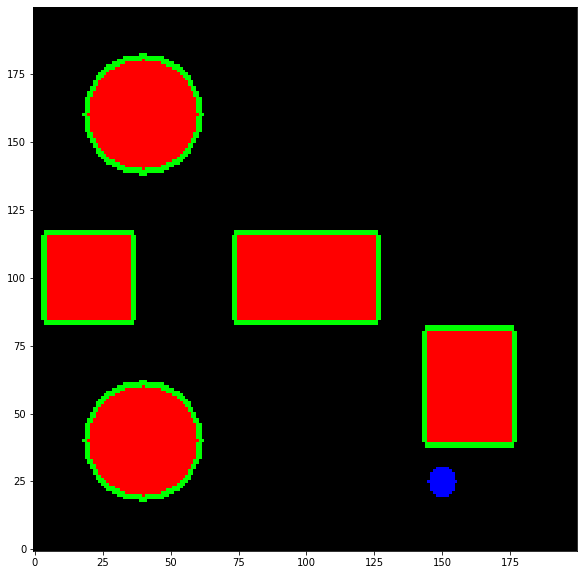

In [18]:
# starting paramters
start_location = [0,0,0]
goal_location = [25,150,0]

# color map size
# board size will be based off of the color map and threshold
width = 200
height = 200

thresh = 1.5

print('Building Color Map')
color_map = create_color_map(height = height, width = width, radius=15, goal_location=goal_location)

print('Building Board')
board = create_board(width=width, height=height, thresh=thresh)

plt.figure(figsize=(10, 10))
plt.imshow(color_map, origin='lower')


In [19]:
compressed_x_start, compressed_y_start, compressed_angle_start = compress_coordinates(
        start_location[1],
        start_location[0],
        start_location[2],
        thresh=thresh
    )

compressed_x_goal, compressed_y_goal, compressed_angle_goal = compress_coordinates(
    goal_location[1],
    goal_location[0],
    goal_location[2],
    thresh=thresh
)

print(f'Starting in region x: {compressed_x_start}, y: {compressed_y_start}, theta: {compressed_angle_start}')
print(f'Goal in region x: {compressed_x_goal}, y: {compressed_y_goal}, theta: {compressed_angle_goal}')


Starting in region x: 0, y: 0, theta: 0
Goal in region x: 100, y: 16, theta: 0


In [20]:
start_node = board[compressed_y_start][compressed_x_start][compressed_angle_start]
goal_node = board[compressed_y_goal][compressed_x_goal][compressed_angle_goal]

start_node.c2c = 0
goal_region = goal_node.region

open_nodes = [start_node]
closed_nodes = []

found = False
solution_path = None
commands = None

print(f'Searching for goal region: {goal_region}')
while len(open_nodes) > 0:

    open_nodes.sort(key=lambda x: x.h)
    curr_node = open_nodes.pop(0)
    closed_nodes.append(curr_node)

    curr_x = curr_node.cell_location[1]
    curr_y = curr_node.cell_location[0]


    print(f"Current node has exact coordinates of x:{curr_x} y:{curr_y} Theta:{curr_node.cell_location[2]}")
    print(f"Current node is in region coordinates of {curr_node.region}")
    # print(f"Current node has coordinates of {curr_node.cell_location}")


    if int(color_map[int(curr_y)][int(curr_x)][0]) == 0 and\
       int(color_map[int(curr_y)][int(curr_x)][1]) == 0 and\
       int(color_map[int(curr_y)][int(curr_x)][2]) == 255:
        print('Found Solution')
        found = True

        print('Animating Search Pattern')          
        # back track and animate the search and solution
        solution_path = get_solution_path(curr_node)
        commands = get_commands(solution_path)
        animate(color_map, closed_nodes, solution_path)

        break

    else:
        next_possible_nodes = gen_next_nodes(
            curr_node=curr_node,
            board=board,
            goal_location=goal_location,
            color_map=color_map,
            thresh=thresh
        )
        
        for node in next_possible_nodes:

            appendable = True
            for o_node in open_nodes:
                if o_node.region == node.region:
                    appendable = False
                    break
            if appendable:
                for c_node in closed_nodes:
                    if c_node.region == node.region:
                        appendable = False
                        break

            if appendable:
                open_nodes.append(node)

if not found:
    print('No Solution')

Searching for goal region: [16, 100, 0]
Current node has exact coordinates of x:0 y:0 Theta:0
Current node is in region coordinates of [0, 0, 0]
Current node has exact coordinates of x:3.5403462244992476 y:0.6756355438723463 Theta:23.78161965423112
Current node is in region coordinates of [0, 2, 2]
Current node has exact coordinates of x:3.630000000000001 y:0.0 Theta:0.0
Current node is in region coordinates of [0, 2, 0]
Current node has exact coordinates of x:7.052699839205436 y:1.4842806222164497 Theta:-7.955419762441408e-16
Current node is in region coordinates of [0, 4, 3]
Current node has exact coordinates of x:7.17034622449925 y:0.6756355438723463 Theta:23.78161965423112
Current node is in region coordinates of [0, 4, 2]
Current node has exact coordinates of x:10.593046063704683 y:2.159916166088796 Theta:23.78161965423112
Current node is in region coordinates of [1, 6, 2]
Current node has exact coordinates of x:7.260000000000002 y:0.0 Theta:0.0
Current node is in region coordinat

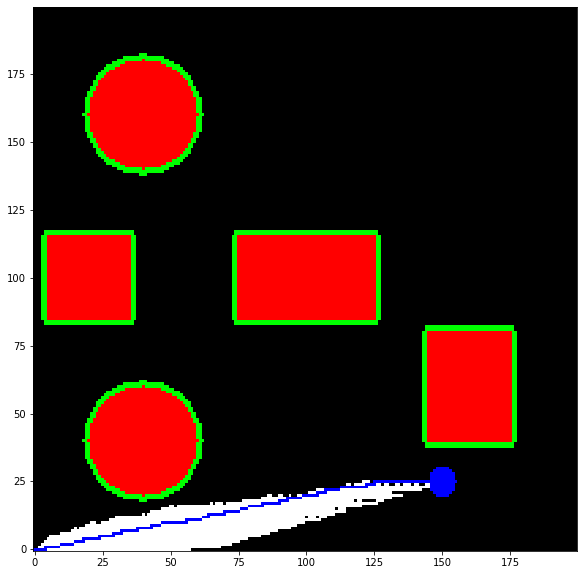

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(color_map, origin = "bottom")

In [22]:
len(commands)

41